# 10. Basic Regression Analysis with Time Series Data

This notebook introduces fundamental concepts and techniques for applying regression analysis to time series data. **Time series data** consists of observations on the same variables recorded sequentially over time (e.g., daily stock prices, monthly unemployment rates, annual GDP). This contrasts with **cross-sectional data** (observations on different units at a single point in time) studied in earlier chapters.

**Key Differences from Cross-Sectional Analysis:**

1. **Temporal ordering matters:** The sequence of observations is meaningful. Past values may influence current values.

2. **Subscript notation:** We use subscript $t$ (time) instead of $i$ (individual) to index observations: $y_t, x_{1t}, \ldots, x_{kt}$ for $t = 1, 2, \ldots, T$.

3. **Modified assumptions:** The random sampling assumption (MLR.2/SLR.2) must be replaced because consecutive time observations are typically **not independent**. Instead, we require:
   - **Stationarity:** Time series have stable distributions over time
   - **Weak dependence:** Observations far apart in time are nearly independent
   - These are discussed in detail in Chapter 11

4. **New issues:** Time series data introduces specific challenges:
   - **Serial correlation (autocorrelation):** Errors may be correlated across time
   - **Trends:** Variables may exhibit long-term growth or decline
   - **Seasonality:** Regular patterns within periods (e.g., monthly, quarterly)
   - **Dynamic relationships:** Current outcomes may depend on past values (lags)

Despite these differences, OLS can still be applied to time series data under appropriate assumptions, and many results from cross-sectional analysis (unbiasedness, consistency, asymptotic normality) carry over with modifications.

We will cover static models, how to handle time series data in Python, finite distributed lag models, trends, and seasonality. We'll use Python libraries like `pandas` for data manipulation, `statsmodels` for regression modeling, and `matplotlib` for plotting. The examples primarily use datasets from the `wooldridge` package.

First, let's ensure the necessary libraries are installed. The `%pip install` command installs packages directly within the Jupyter environment. The `-q` flag suppresses installation output for a cleaner notebook.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge -q

Now, we import the libraries we'll be using throughout the notebook.

In [2]:
import matplotlib.pyplot as plt  # For creating plots
import numpy as np  # For numerical operations (though not heavily used directly here, often needed alongside pandas) # noqa
import pandas as pd  # For data manipulation and handling time series
import statsmodels.formula.api as smf  # For statistical modeling, particularly OLS regression
import wooldridge as wool  # For accessing Wooldridge textbook datasets

## 10.1 Static Time Series Models

A **static time series model** is one where the dependent variable $y_t$ at time $t$ is modeled as a contemporaneous function of explanatory variables $z_{1t}, ..., z_{kt}$ from the *same* time period $t$. The relationship is assumed to be constant across time, aside from the error term $u_t$.

The general form is:
$$ y_t = \beta_0 + \beta_1 z_{1t} + \beta_2 z_{2t} + \cdots + \beta_k z_{kt} + u_t $$

Here, $\beta_j$ measures the *contemporaneous* effect of a change in $z_{jt}$ on $y_t$.

### Example 10.2 Effects of Inflation and Deficits on Interest Rates

We'll investigate how the 3-month T-bill interest rate (`i3`) is related to the inflation rate (`inf`) and the federal budget deficit (`def`) using annual data. This is a static model because we assume the interest rate in a given year depends only on inflation and the deficit in that *same* year.

In [3]:
# Load the interest rate/inflation/deficit dataset
intdef = wool.dataWoo("intdef")

print(f"Dataset info: {intdef.shape[0]} years, {intdef.shape[1]} variables")
print(f"Time span: {intdef.index.min()} to {intdef.index.max()}")

# Estimate static time series model: i3_t = β₀ + β₁*inf_t + β₂*def_t + u_t
# Static = all variables from same time period (no lags)
# Q() protects variable names that could be Python keywords or operators
static_model = smf.ols(
    formula='i3 ~ Q("inf") + Q("def")',  # i3: 3-month T-bill rate
    data=intdef,
)

# Fit model using OLS (appropriate under time series assumptions)
results = static_model.fit()

# Display the results in a formatted table.
# We extract coefficients (b), standard errors (se), t-statistics (t), and p-values (pval).
table = pd.DataFrame(
    {
        "b": round(results.params, 4),  # Estimated coefficients
        "se": round(results.bse, 4),  # Standard errors of the coefficients
        "t": round(
            results.tvalues,
            4,
        ),  # t-statistics for hypothesis testing (H0: beta = 0)
        "pval": round(results.pvalues, 4),  # p-values associated with the t-statistics
    },
)
print(f"Regression Results (Dependent Variable: i3): \n{table}\n")

# Interpretation:
# - The coefficient on 'inf' (inflation) is 0.6059. This suggests that a 1 percentage point increase
#   in inflation is associated with about a 0.61 percentage point increase in the 3-month T-bill rate,
#   holding the deficit constant. This effect is statistically significant (p-value < 0.0001).
# - The coefficient on 'def' (deficit) is 0.5131. This suggests that a 1 percentage point increase
#   in the deficit (relative to GDP) is associated with about a 0.51 percentage point increase in the
#   T-bill rate, holding inflation constant. This effect is also statistically significant (p-value = 0.0001).
# - The intercept (1.7333) represents the predicted T-bill rate when both inflation and deficit are zero.

Regression Results (Dependent Variable: i3): 
                b      se       t    pval
Intercept  1.7333  0.4320  4.0125  0.0002
Q("inf")   0.6059  0.0821  7.3765  0.0000
Q("def")   0.5131  0.1184  4.3338  0.0001



## 10.2 Time Series Data Types in Python

Working with time series data often requires specific tools to handle dates and the temporal ordering of observations. `pandas` is the primary library in Python for this. It provides data structures like `DateTimeIndex` which allow for easy manipulation, plotting, and analysis of time series data.

### 10.2.1 Equispaced Time Series in Python

An **equispaced time series** is one where observations are recorded at regular, equal intervals (e.g., hourly, daily, monthly, quarterly, annually).

Let's load the `barium` dataset, which contains monthly data. We will assign a proper time series index to it.

In [4]:
# Load the 'barium' dataset
barium = wool.dataWoo("barium")
T = len(barium)  # Get the total number of observations (time periods)

# Create a monthly DateTimeIndex starting from February 1978.
# pd.date_range generates a sequence of dates.
# start="1978-02" sets the beginning date.
# periods=T specifies the total number of dates to generate.
# freq="ME" indicates Month End frequency. This means each date corresponds to the end of the month.
barium.index = pd.date_range(start="1978-02", periods=T, freq="ME")

# Display the first few observations of the 'chnimp' variable (Chinese imports)
# Notice the index now shows the dates.
print(f'barium["chnimp"].head(): \n{barium["chnimp"].head()}\n')

barium["chnimp"].head(): 
1978-02-28    220.462006
1978-03-31     94.797997
1978-04-30    219.357498
1978-05-31    317.421509
1978-06-30    114.639000
Freq: ME, Name: chnimp, dtype: float64



Having a `DateTimeIndex` makes plotting straightforward. `pandas` and `matplotlib` recognize the index and use it for the x-axis automatically.

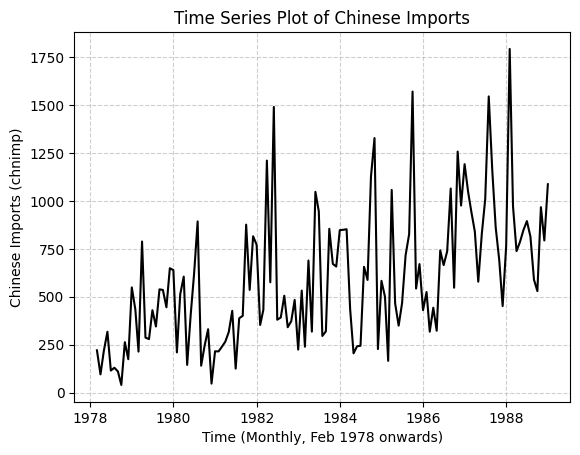

In [5]:
# Plot the 'chnimp' variable over time.
# By default, pandas plotting uses the DataFrame's index for the x-axis.
plt.plot("chnimp", data=barium, color="black", linestyle="-")
plt.ylabel("Chinese Imports (chnimp)")
plt.xlabel("Time (Monthly, Feb 1978 onwards)")
plt.title("Time Series Plot of Chinese Imports")
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid for better readability
plt.show()

# Interpretation:
# The plot shows the evolution of Chinese imports over the observed period.
# We can visually inspect the series for trends (e.g., upward trend here),
# seasonality (cyclical patterns within years), or structural breaks.

## 10.3 Other Time Series Models

Static models are often too restrictive. Economic variables frequently exhibit inertia or delayed responses. We need models that incorporate dynamics, trends, and seasonality.

### 10.3.1 Finite Distributed Lag Models

A **Finite Distributed Lag (FDL)** model allows the dependent variable $y_t$ to depend on current *and past* values of an explanatory variable $z_t$. This captures delayed effects.

The general form of an FDL model with $k$ lags is:
$$ y_t = \alpha_0 + \delta_0 z_t + \delta_1 z_{t-1} + \cdots + \delta_k z_{t-k} + u_t $$

- $\delta_0$ is the **impact propensity** or **impact multiplier**: the immediate change in $y_t$ due to a one-unit change in $z_t$.
- $\delta_j$ (for $j > 0$) measures the change in $y_t$ resulting from a one-unit change in $z$ that occurred $j$ periods ago ($z_{t-j}$).
- The sum $\sum_{j=0}^{k} \delta_j$ is the **Long-Run Propensity (LRP)** or **total multiplier**: the total change in $y$ after a permanent one-unit increase in $z$ has fully worked its way through the system.

### Example 10.4 Effects of Personal Exemption on Fertility Rates

We examine the effect of the real dollar value of the personal tax exemption (`pe`) on the general fertility rate (`gfr`), using annual data from `fertil3`. It's plausible that changes in `pe` might affect fertility decisions with a delay, making an FDL model appropriate. We'll include lags up to two years ($k=2$). We also control for the effects of World War II (`ww2`) and the availability of the birth control pill (`pill`).

In [6]:
# Load the 'fertil3' dataset
fertil3 = wool.dataWoo("fertil3")
T = len(fertil3)

# Define a yearly time index starting in 1913.
# freq='YE' indicates Year End frequency. .year extracts just the year part for a simpler index display.
fertil3.index = pd.date_range(start="1913", periods=T, freq="YE").year

# Create lagged variables for 'pe'.
# .shift(1) creates a one-period lag (pe_{t-1}).
# .shift(2) creates a two-period lag (pe_{t-2}).
# Note: Creating lags introduces missing values (NaN) at the beginning of the series.
# OLS in statsmodels automatically handles these by dropping the corresponding rows.
fertil3["pe_lag1"] = fertil3["pe"].shift(1)
fertil3["pe_lag2"] = fertil3["pe"].shift(2)

# Estimate the FDL model using OLS.
# The formula includes current 'pe' and its two lags.
reg = smf.ols(formula="gfr ~ pe + pe_lag1 + pe_lag2 + ww2 + pill", data=fertil3)
results = reg.fit()

# Display the regression results.
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"FDL Model Results (Dependent Variable: gfr): \n{table}\n")

# Interpretation:
# - The coefficient on 'pe' (delta_0) is 0.0727, suggesting a small positive immediate effect, but it's not statistically significant (p=0.56).
# - The coefficient on 'pe_lag1' (delta_1) is -0.0058, small and insignificant (p=0.97).
# - The coefficient on 'pe_lag2' (delta_2) is 0.0338 but not statistically significant (p=0.79). This suggests that an increase
#   in the personal exemption two years prior is associated with a small increase in the current fertility rate.
# - The dummy variables 'ww2' and 'pill' have large, negative, and highly significant coefficients, as expected.

FDL Model Results (Dependent Variable: gfr): 
                 b       se        t    pval
Intercept  95.8705   3.2820  29.2114  0.0000
pe          0.0727   0.1255   0.5789  0.5647
pe_lag1    -0.0058   0.1557  -0.0371  0.9705
pe_lag2     0.0338   0.1263   0.2679  0.7896
ww2       -22.1265  10.7320  -2.0617  0.0433
pill      -31.3050   3.9816  -7.8625  0.0000



### Example 10.4 (continued) - Hypothesis Testing in FDL Models

Often, we want to test hypotheses involving multiple lag coefficients.

**1. Joint Significance of Lags:**
We can test if the explanatory variable `pe` has *any* effect, short-run or long-run, by testing the null hypothesis that all its lag coefficients are zero: $H_0: \delta_0 = 0, \delta_1 = 0, \delta_2 = 0$. We use an F-test for this.

In [7]:
# F-test for the joint significance of pe, pe_lag1, and pe_lag2.
# H0: pe = 0, pe_lag1 = 0, pe_lag2 = 0
hypotheses1 = ["pe = 0", "pe_lag1 = 0", "pe_lag2 = 0"]
ftest1 = results.f_test(hypotheses1)
fstat1 = ftest1.statistic  # Extract F-statistic value
fpval1 = ftest1.pvalue

print(f"F-statistic for joint significance of pe lags: {fstat1:.4f}")
print(f"P-value for joint significance test: {fpval1:.4f}\n")

# Interpretation:
# The F-statistic is 3.97 and the p-value is 0.012. Since the p-value is less than 0.05,
# we reject the null hypothesis at the 5% significance level. This suggests that the personal
# exemption (considering its current and past two values) jointly has a statistically significant effect on the fertility rate.

F-statistic for joint significance of pe lags: 3.9730
P-value for joint significance test: 0.0117



**2. Calculating and Testing the Long-Run Propensity (LRP):**
The LRP measures the total long-term effect of a sustained change in `pe`. It's calculated as the sum of the coefficients on the current and lagged `pe` variables: $LRP = \delta_0 + \delta_1 + \delta_2$.

In [8]:
# Calculate the Long-Run Propensity (LRP)
b = results.params
b_pe_tot = b["pe"] + b["pe_lag1"] + b["pe_lag2"]
print(f"Estimated Long-Run Propensity (LRP) for pe: {b_pe_tot:.4f}\n")

# Interpretation:
# The estimated LRP is 0.1007. This suggests that a permanent $1 increase in the real personal exemption
# is predicted to lead to an increase of about 0.1007 births per 1000 women of childbearing age in the long run.

Estimated Long-Run Propensity (LRP) for pe: 0.1007



We can also test whether the LRP is statistically different from zero using an F-test (or a t-test, as it's a single linear restriction). $H_0: \delta_0 + \delta_1 + \delta_2 = 0$.

In [9]:
# F-test for the null hypothesis that the LRP is zero.
# H0: pe + pe_lag1 + pe_lag2 = 0
hypotheses2 = ["pe + pe_lag1 + pe_lag2 = 0"]
ftest2 = results.f_test(hypotheses2)
fstat2 = ftest2.statistic  # Extract F-statistic value
fpval2 = ftest2.pvalue

print(f"F-statistic for H0: LRP = 0: {fstat2:.4f}")
print(f"P-value for LRP test: {fpval2:.4f}\n")

# Interpretation:
# The F-statistic is 11.42 and the p-value is 0.001. We reject the null hypothesis
# that the LRP is zero. This suggests that the estimated overall long-run effect is statistically
# different from zero at conventional levels.

F-statistic for H0: LRP = 0: 11.4212
P-value for LRP test: 0.0012



### 10.3.2 Trends

Many economic time series exhibit **trends**, meaning they tend to grow or decline systematically over time. This can be due to factors like technological progress, population growth, or changing tastes. If the dependent variable and one or more independent variables are trending, failing to account for the trend can lead to **spurious regression**, where a relationship appears significant even if none truly exists beyond the common trend.

A common way to account for a trend is to include a time trend variable, $t = 1, 2, 3, ...$, directly in the regression model:
$$ y_t = \beta_0 + \beta_1 x_{1t} + \cdots + \beta_k x_{kt} + \gamma t + u_t $$
The coefficient $\gamma$ captures the average change in $y_t$ per time period, holding the other factors constant.

### Example 10.7 Housing Investment and Prices

We examine the relationship between housing investment per capita (`invpc`) and a housing price index (`price`), using annual data. Both variables might be trending over time. We first estimate a model *without* a trend, and then *with* a trend.

In [10]:
# Load the 'hseinv' dataset
hseinv = wool.dataWoo("hseinv")

# --- Regression WITHOUT time trend ---
# We model log(investment) as a function of log(price). Logs are used to model elasticities
# and potentially stabilize variance.
reg_wot = smf.ols(formula="np.log(invpc) ~ np.log(price)", data=hseinv)
results_wot = reg_wot.fit()

# Display results without trend
table_wot = pd.DataFrame(
    {
        "b": round(results_wot.params, 4),
        "se": round(results_wot.bse, 4),
        "t": round(results_wot.tvalues, 4),
        "pval": round(results_wot.pvalues, 4),
    },
)
print("--- Regression Results WITHOUT Trend ---")
print("Dependent Variable: np.log(invpc)")
print(f"table_wot: \n{table_wot}\n")

# Interpretation (without trend):
# The estimated elasticity of investment with respect to price is 1.2409.
# This seems very high and is statistically significant (p=0.002).
# However, this might be misleading if both variables are driven by a common time trend.

--- Regression Results WITHOUT Trend ---
Dependent Variable: np.log(invpc)
table_wot: 
                    b      se        t    pval
Intercept     -0.5502  0.0430 -12.7882  0.0000
np.log(price)  1.2409  0.3824   3.2450  0.0024



Now, let's add a linear time trend (`t`) to the model. The `hseinv` dataset already includes a variable `t` representing the time period.

In [11]:
# --- Regression WITH time trend ---
# The dataset includes a variable 't' which serves as the time trend (t=1, 2, ...).
reg_wt = smf.ols(formula="np.log(invpc) ~ np.log(price) + t", data=hseinv)
results_wt = reg_wt.fit()

# Display results with trend
table_wt = pd.DataFrame(
    {
        "b": round(results_wt.params, 4),
        "se": round(results_wt.bse, 4),
        "t": round(results_wt.tvalues, 4),
        "pval": round(results_wt.pvalues, 4),
    },
)
print("--- Regression Results WITH Trend ---")
print("Dependent Variable: np.log(invpc)")
print(f"table_wt: \n{table_wt}\n")

# Interpretation (with trend):
# - The coefficient on log(price) drops dramatically to -0.3810 and is no longer statistically
#   significant (p=0.58). This suggests the strong positive relationship found earlier was likely
#   due to both variables trending upwards over time. Once the trend is controlled for, the
#   contemporaneous relationship between price changes and investment changes is much weaker.
# - The coefficient on the time trend 't' is 0.0098 and statistically significant (p=0.008).
#   This indicates that, holding housing prices constant, housing investment per capita tended
#   to increase by about 0.98% per year over this period. This process of including a trend
#   to isolate the relationship between other variables is sometimes called 'detrending'.

--- Regression Results WITH Trend ---
Dependent Variable: np.log(invpc)
table_wt: 
                    b      se       t    pval
Intercept     -0.9131  0.1356 -6.7328  0.0000
np.log(price) -0.3810  0.6788 -0.5612  0.5779
t              0.0098  0.0035  2.7984  0.0079



### 10.3.3 Seasonality

**Seasonality** refers to patterns in time series data that repeat over a fixed period, such as a year, quarter, or month. For example, retail sales often peak in the fourth quarter, and ice cream sales peak in the summer.

Ignoring seasonality when it is present can bias the estimates of other coefficients. A common way to handle seasonality is to include a set of **seasonal dummy variables**. For monthly data, we would include 11 dummy variables (e.g., `feb`, `mar`, ..., `dec`), leaving one month (e.g., January) as the base or reference category. The coefficient on a monthly dummy represents the average difference in the dependent variable for that month compared to the base month, holding other factors constant.

### Example 10.11 Effects of Antidumping Filings

We model the log of Chinese imports (`chnimp`) using monthly data from the `barium` dataset. Explanatory variables include log chemical price index (`chempi`), log price of gas (`gas`), log real trade weighted exchange rate (`rtwex`), and dummy variables related to antidumping filings (`befile6`, `affile6`, `afdec6`). We also include monthly dummy variables (`feb` through `dec`) to control for seasonality. January is the omitted base month.

In [12]:
# Load the 'barium' dataset again (if not already loaded with time index)
barium = wool.dataWoo("barium")
T = len(barium)
# Ensure the DateTimeIndex is set for potential time-based operations (though not strictly needed for dummies)
barium.index = pd.date_range(start="1978-02", periods=T, freq="ME")

# Estimate the regression model including economic variables and monthly dummies.
# The dataset already contains dummy variables feb, mar, ..., dec (coded 1 for the respective month, 0 otherwise).
# January is the omitted base category.
reg_seas = smf.ols(
    formula="np.log(chnimp) ~ np.log(chempi) + np.log(gas) +"
    "np.log(rtwex) + befile6 + affile6 + afdec6 +"
    "feb + mar + apr + may + jun + jul +"
    "aug + sep + oct + nov + dec",
    data=barium,
)
results_seas = reg_seas.fit()

# Display the regression results.
table_seas = pd.DataFrame(
    {
        "b": round(results_seas.params, 4),
        "se": round(results_seas.bse, 4),
        "t": round(results_seas.tvalues, 4),
        "pval": round(results_seas.pvalues, 4),
    },
)
print("Regression Results with Monthly Dummies (Dependent Variable: np.log(chnimp)):")
print("(Base month: January)")
print(f"table: \n{table_seas}\n")

# Interpretation:
# - The coefficients on the economic variables (log(chempi), log(gas), etc.) now represent their effects
#   after controlling for average seasonal patterns. For example, the coefficient on `befile6` (0.0598, p=0.54)
#   estimates the percentage change in imports in the 6 months before an antidumping filing, holding other factors
#   and the average month constant. `affile6` (after filing) is negative (-0.1719) and significant (p=0.08).
# - The coefficients on the monthly dummies show how imports typically vary throughout the year compared to January.
#   For instance, the coefficient on 'dec' is 0.1819 (p=0.05), suggesting that imports in December are, on average,
#   about 18.2% higher than in January, holding other factors constant. Several other monthly dummies are also significant.
# - We should formally test the joint significance of the monthly dummies to confirm seasonality is important.

# F-test for joint significance of seasonal dummies
seasonal_dummies = [
    "feb",
    "mar",
    "apr",
    "may",
    "jun",
    "jul",
    "aug",
    "sep",
    "oct",
    "nov",
    "dec",
]
hypotheses_seas = [f"{dummy} = 0" for dummy in seasonal_dummies]
ftest_seas = results_seas.f_test(hypotheses_seas)
fstat_seas = ftest_seas.statistic
fpval_seas = ftest_seas.pvalue

print("--- Joint Test for Seasonality ---")
print("H0: All monthly dummy coefficients are zero")
print(f"F-statistic for joint significance of seasonal dummies: {fstat_seas:.4f}")
print(f"P-value for seasonality test: {fpval_seas:.4f}\n")

# Interpretation of Seasonality Test:
# The F-statistic is 0.86 and the p-value is 0.59.
# We fail to reject the null hypothesis that all monthly dummy coefficients are zero.
# This suggests that there is no significant seasonality in Chinese imports, indicating that
# monthly dummies are not necessary for this particular model.

Regression Results with Monthly Dummies (Dependent Variable: np.log(chnimp)):
(Base month: January)
table: 
                      b       se       t    pval
Intercept       16.7792  32.4286  0.5174  0.6059
np.log(chempi)   3.2651   0.4929  6.6238  0.0000
np.log(gas)     -1.2781   1.3890 -0.9202  0.3594
np.log(rtwex)    0.6630   0.4713  1.4068  0.1622
befile6          0.1397   0.2668  0.5236  0.6016
affile6          0.0126   0.2787  0.0453  0.9639
afdec6          -0.5213   0.3019 -1.7264  0.0870
feb             -0.4177   0.3044 -1.3720  0.1728
mar              0.0591   0.2647  0.2231  0.8239
apr             -0.4515   0.2684 -1.6822  0.0953
may              0.0333   0.2692  0.1237  0.9018
jun             -0.2063   0.2693 -0.7663  0.4451
jul              0.0038   0.2788  0.0138  0.9890
aug             -0.1571   0.2780 -0.5650  0.5732
sep             -0.1342   0.2677 -0.5012  0.6172
oct              0.0517   0.2669  0.1937  0.8467
nov             -0.2463   0.2628 -0.9370  0.3508
dec       

This concludes the introduction to basic regression analysis with time series data, covering static models, FDL models, trends, and seasonality using Python. More advanced topics include dealing with serial correlation and non-stationarity.